In [1]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size
    
    def scalar(img):
        return img  # Placeholder for a real preprocessing function
    
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rotation_range=15,  # Adjust as needed
        width_shift_range=0.1,  # Adjust as needed
        height_shift_range=0.1,  # Adjust as needed
        zoom_range=0.1,  # Adjust as needed
        brightness_range=[0.8, 1.2]  # Adjust as needed
    )
    
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)
    
    train_gen = tr_gen.flow_from_dataframe(
        train_df, 
        x_col='filepaths', 
        y_col='labels', 
        target_size=img_size, 
        class_mode='categorical',
        color_mode='rgb', 
        shuffle=True, 
        batch_size=batch_size
    )
    
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, 
        x_col='filepaths', 
        y_col='labels', 
        target_size=img_size, 
        class_mode='categorical',
        color_mode='rgb', 
        shuffle=True, 
        batch_size=batch_size
    )
    
    test_gen = ts_gen.flow_from_dataframe(
        test_df, 
        x_col='filepaths', 
        y_col='labels', 
        target_size=img_size, 
        class_mode='categorical',
        color_mode='rgb', 
        shuffle=False, 
        batch_size=test_batch_size
    )
    
    return train_gen, valid_gen, test_gen


In [7]:
# Get Dataframes
train_dir = 'Data/train'
test_dir = 'Data/valid'
valid_dir = 'Data/test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 613 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.


In [16]:
train_df.head()

filepaths  \
0  Data/train\adenocarcinoma_left.lower.lobe_T2_N...   
1  Data/train\adenocarcinoma_left.lower.lobe_T2_N...   
2  Data/train\adenocarcinoma_left.lower.lobe_T2_N...   
3  Data/train\adenocarcinoma_left.lower.lobe_T2_N...   
4  Data/train\adenocarcinoma_left.lower.lobe_T2_N...   

                                       labels  
0  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib  
1  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib  
2  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib  
3  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib  
4  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib

In [18]:
# Define a function to display random images
def display_random_images(df, num_images, rows, cols):
    # Ensure the number of images does not exceed the number of available images
    num_images = min(num_images, len(df))
    
    # Randomly select indices
    random_indices = random.sample(range(len(df)), num_images)
    
    # Set up the plot
    plt.figure(figsize=(15, 15))
    
    for i, idx in enumerate(random_indices):
        image_path = df.iloc[idx]['filepaths']
        label = df.iloc[idx]['labels']
        
        # Load the image
        img = Image.open(image_path)
        
        # Display the image in the grid
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.array(img))
        plt.title(label, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 25 random images in a 5x5 grid

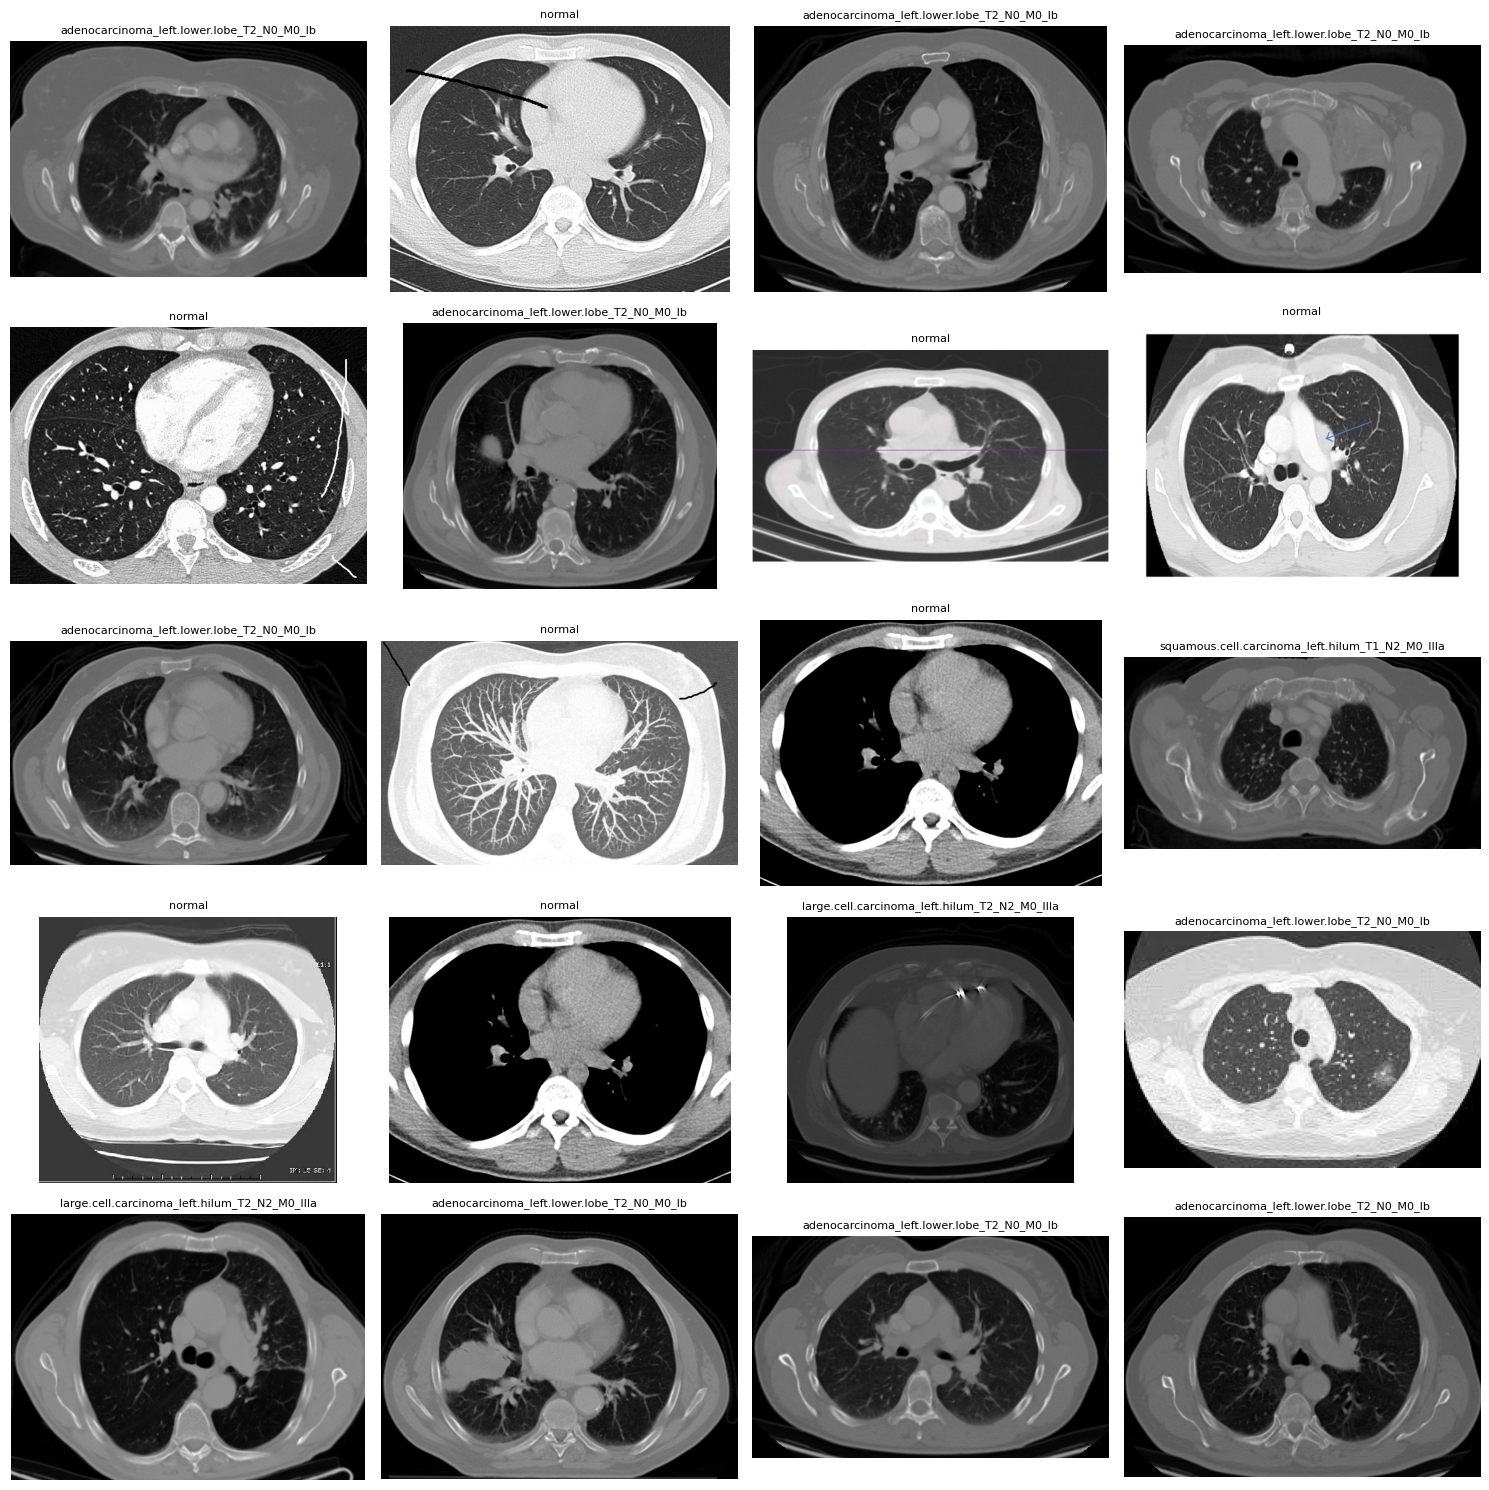

In [20]:
display_random_images(train_df, 20,5,4)  # Update with your actual file path


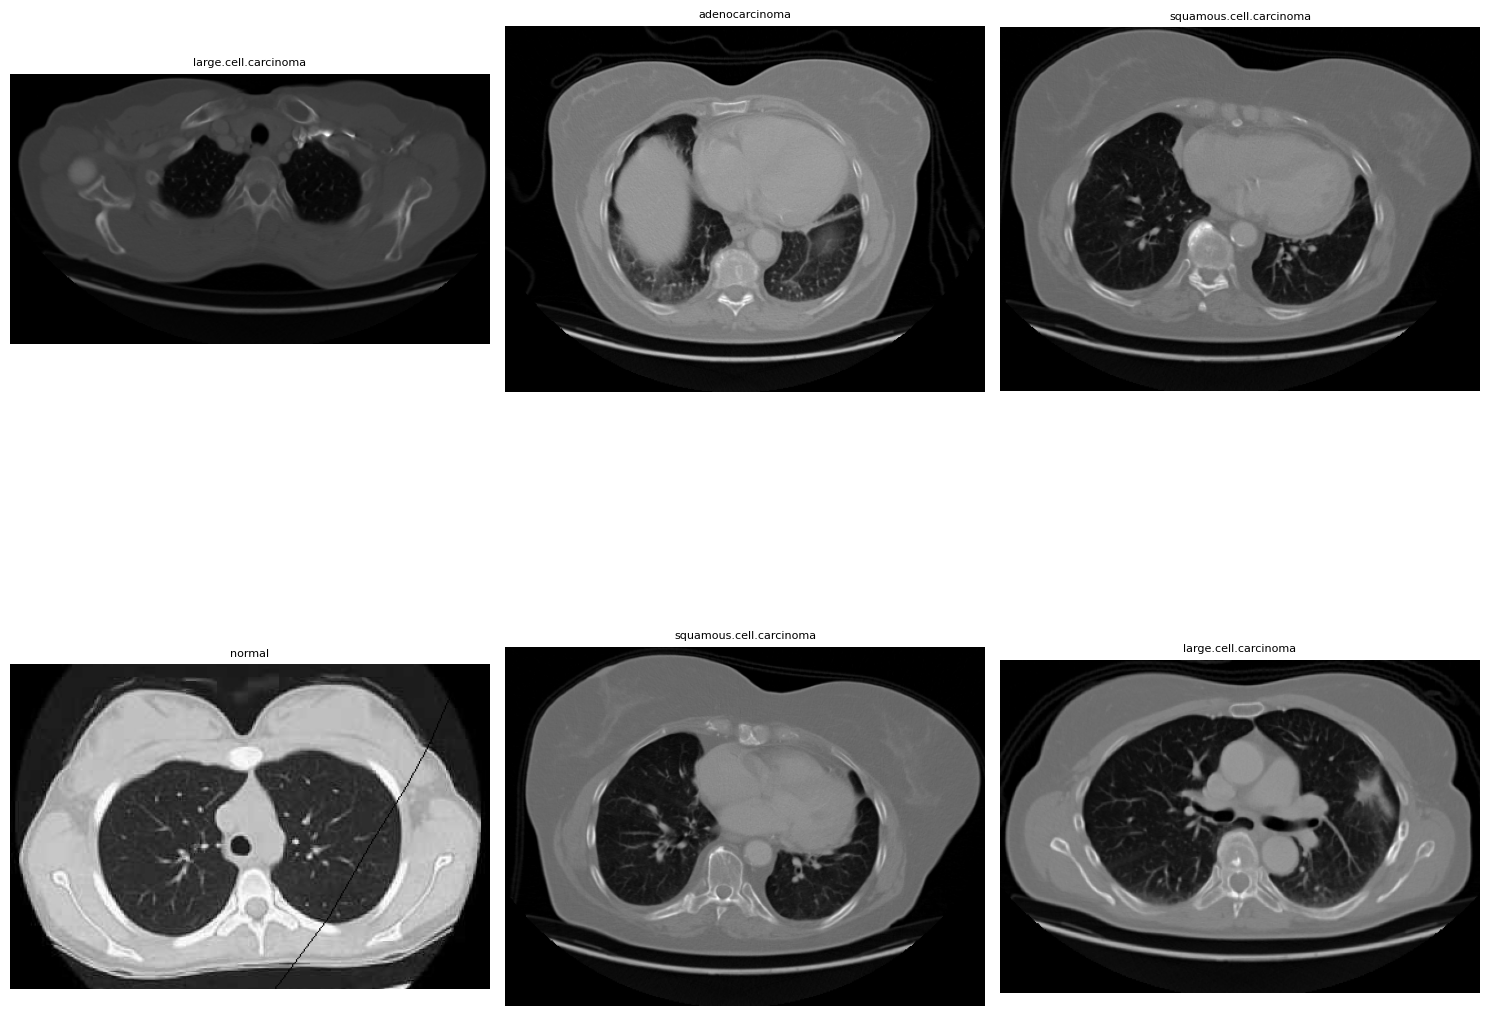

In [21]:
display_random_images(valid_df, num_images=6, rows=2, cols=3)

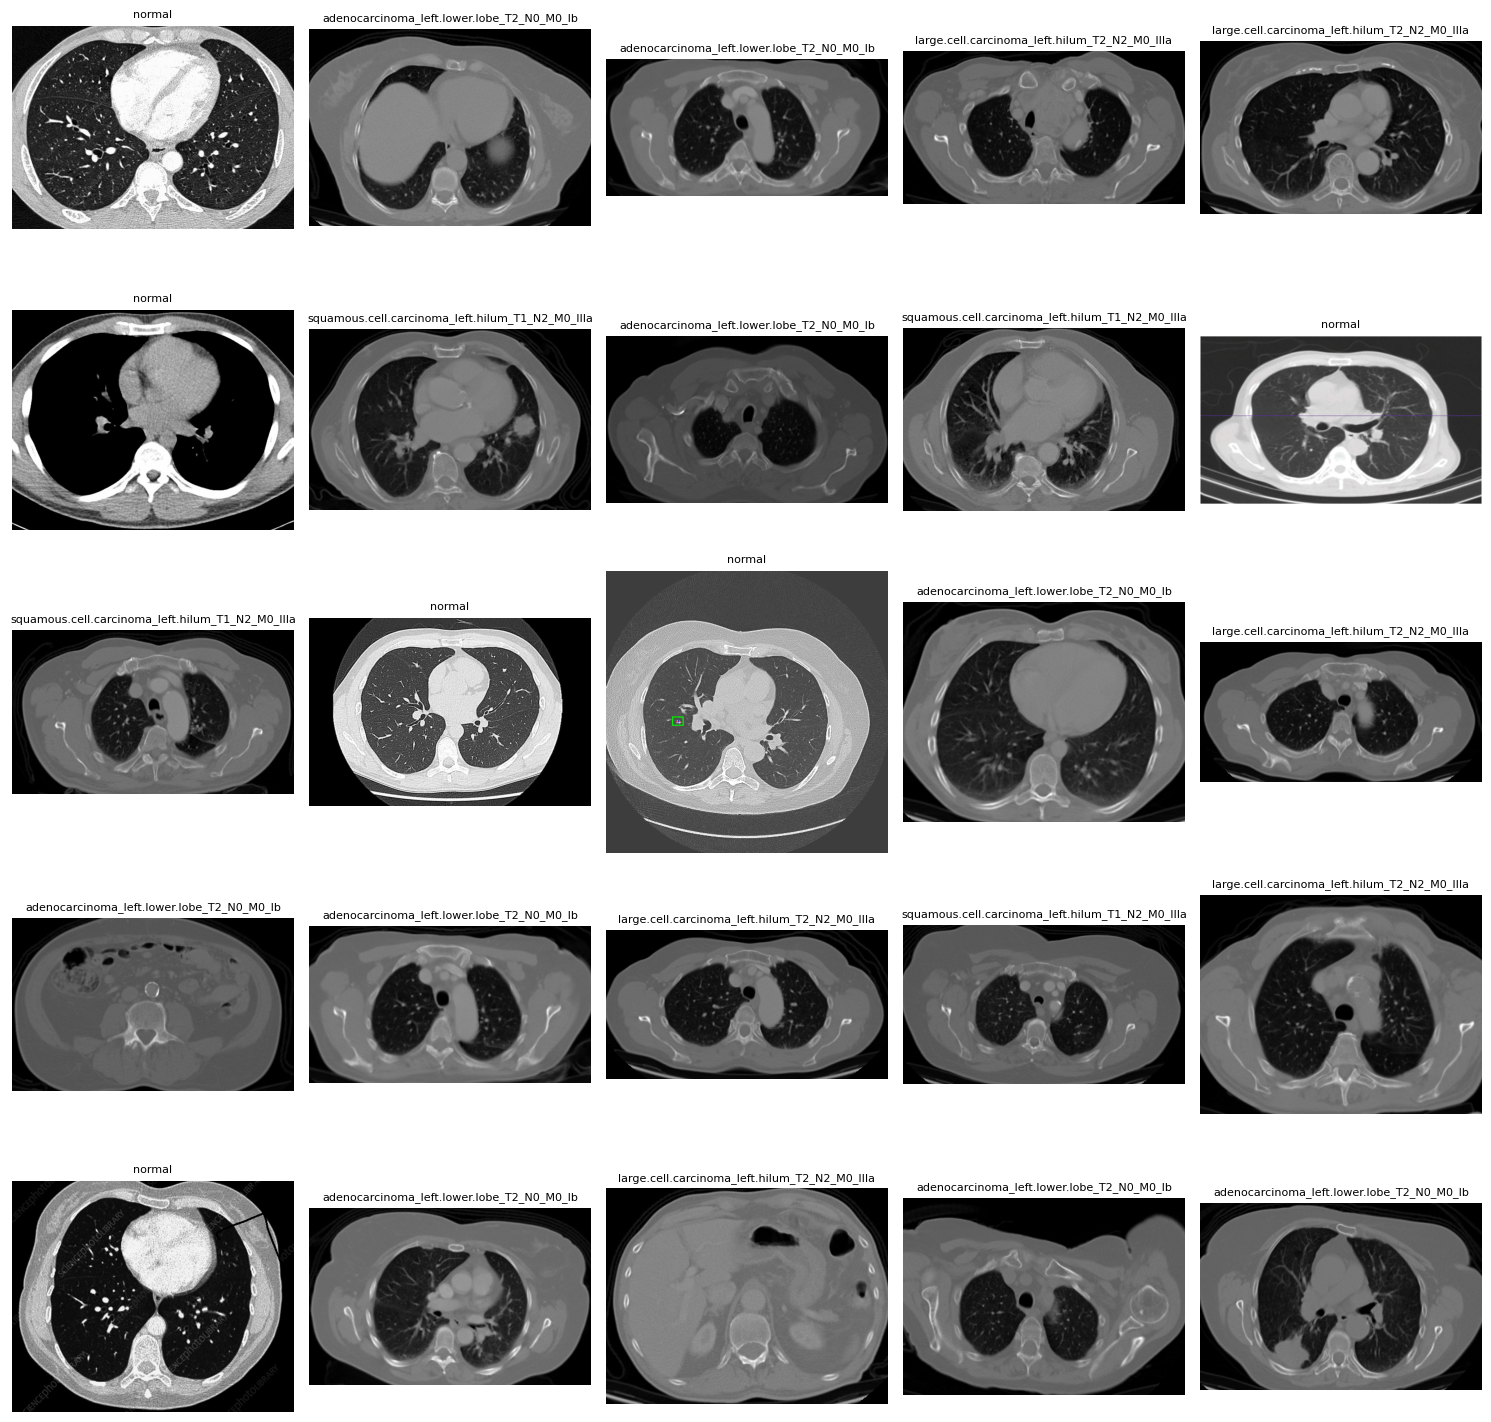

In [22]:
display_random_images(test_df, num_images=25, rows=5, cols=5)